Project by Tiago Garcia - 54938 and Miguel Seabra - 56344

First we look at the info of the full datatset and then we view a sample from this dataset so that we can create a subset of it:

Central node: 813286


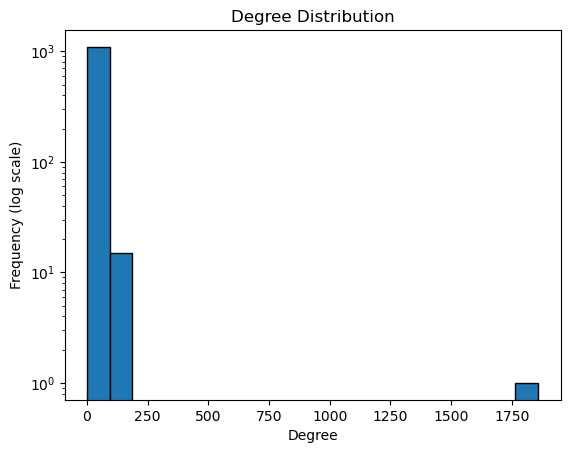

Computing Average clustering coefficient...
Computing Number of triangles...
Computing Fraction of closed triangles...

Subset Metrics:
Nodes: 1112
Edges: 7905
Nodes in largest WCC: 1112
Edges in largest WCC: 7905
Nodes in largest SCC: 967
Edges in largest SCC: 7553
Average clustering coefficient: 0.5758520841980064
Number of triangles: 15178
Fraction of closed triangles: 0.060499525665861496
Approximate diameter: 4
90-percentile effective diameter: 3.0
Number of communities: 14
Modularity score: 0.4942784308706154


In [230]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# Load graph as directed
file_path = "twitter_combined.txt"  # Replace with your dataset path
s_G = nx.read_edgelist(file_path, create_using=nx.DiGraph())

# Extract ego network for the central node
degree_centrality = nx.degree_centrality(s_G)
central_node = max(degree_centrality, key=degree_centrality.get)
print("Central node:", central_node)
subset_G = nx.ego_graph(s_G, central_node, radius=1, undirected=False)

# Helper: Compute metrics safely with progress logs
def compute_metric(name, func, *args, **kwargs):
    try:
        print(f"Computing {name}...")
        return func(*args, **kwargs)
    except Exception as e:
        print(f"Error computing {name}: {e}")
        return "N/A"

# Approximate diameter using random sampling
def approximate_diameter(graph, sample_size=100):
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    max_eccentricity = 0
    for node in sampled_nodes:
        lengths = nx.single_source_shortest_path_length(graph, node)
        if lengths:
            eccentricity = max(lengths.values())
            max_eccentricity = max(max_eccentricity, eccentricity)
    return max_eccentricity

# Calculate 90-percentile effective diameter
def effective_diameter(graph, sample_size=1000):
    nodes = list(graph.nodes())
    sampled_pairs = random.sample([(u, v) for u in nodes for v in nodes if u != v], min(sample_size, len(nodes)**2))
    shortest_paths = []
    for source, target in sampled_pairs:
        try:
            path_length = nx.shortest_path_length(graph, source, target)
            shortest_paths.append(path_length)
        except nx.NetworkXNoPath:
            continue
    return np.percentile(shortest_paths, 90) if shortest_paths else "N/A"

# Compute degree distribution
def compute_degree_distribution(graph):
    degree_sequence = [degree for _, degree in graph.degree()]
    plt.hist(degree_sequence, bins=20, edgecolor="black", log=True)
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency (log scale)")
    plt.savefig("degree_distribution.png", dpi=300)
    plt.show()
    return degree_sequence

# Compute modularity and communities
def compute_modularity(graph):
    communities = nx.community.louvain_communities(graph.to_undirected(), seed=42)
    modularity_score = nx.community.modularity(graph.to_undirected(), communities)
    return len(communities), modularity_score

# Compute SCC and WCC metrics
def compute_scc_wcc(graph):
    # Strongly Connected Components (SCC)
    largest_scc = max(nx.strongly_connected_components(graph), key=len, default=[])
    largest_scc_subgraph = graph.subgraph(largest_scc)
    num_scc_nodes = len(largest_scc)
    num_scc_edges = largest_scc_subgraph.number_of_edges()

    # Weakly Connected Components (WCC)
    largest_wcc = max(nx.weakly_connected_components(graph), key=len, default=[])
    largest_wcc_subgraph = graph.subgraph(largest_wcc)
    num_wcc_nodes = len(largest_wcc)
    num_wcc_edges = largest_wcc_subgraph.number_of_edges()

    return num_scc_nodes, num_scc_edges, num_wcc_nodes, num_wcc_edges

    
# Compute metrics for the directed subset graph
degree_distribution = compute_degree_distribution(subset_G)
approx_diameter = approximate_diameter(subset_G)
effective_diam = effective_diameter(subset_G)
num_communities, modularity_score = compute_modularity(subset_G)
nodes_in_scc, edges_in_scc, nodes_in_wcc, edges_in_wcc = compute_scc_wcc(subset_G)

subset_metrics = {
    "Nodes": subset_G.number_of_nodes(),
    "Edges": subset_G.number_of_edges(),
    "Nodes in largest WCC": nodes_in_wcc,
    "Edges in largest WCC": edges_in_wcc,
    "Nodes in largest SCC": nodes_in_scc,
    "Edges in largest SCC": edges_in_scc,
    "Average clustering coefficient": compute_metric("Average clustering coefficient", nx.average_clustering, subset_G.to_undirected()),
    "Number of triangles": compute_metric("Number of triangles", lambda g: sum(nx.triangles(g.to_undirected()).values()) // 3, subset_G),
    "Fraction of closed triangles": compute_metric("Fraction of closed triangles", nx.transitivity, subset_G.to_undirected()),
    "Approximate diameter": approx_diameter,
    "90-percentile effective diameter": effective_diam,
    "Number of communities": num_communities,
    "Modularity score": modularity_score,
}

# Output the subset metrics
print("\nSubset Metrics:")
for key, value in subset_metrics.items():
    print(f"{key}: {value}")


We now detect communities with the louvain algorithm and analyse them:

Total number of communities: 15
Sizes of communities: [40, 23, 23, 76, 68, 60, 60, 107, 9, 28, 54, 436, 74, 35, 19]


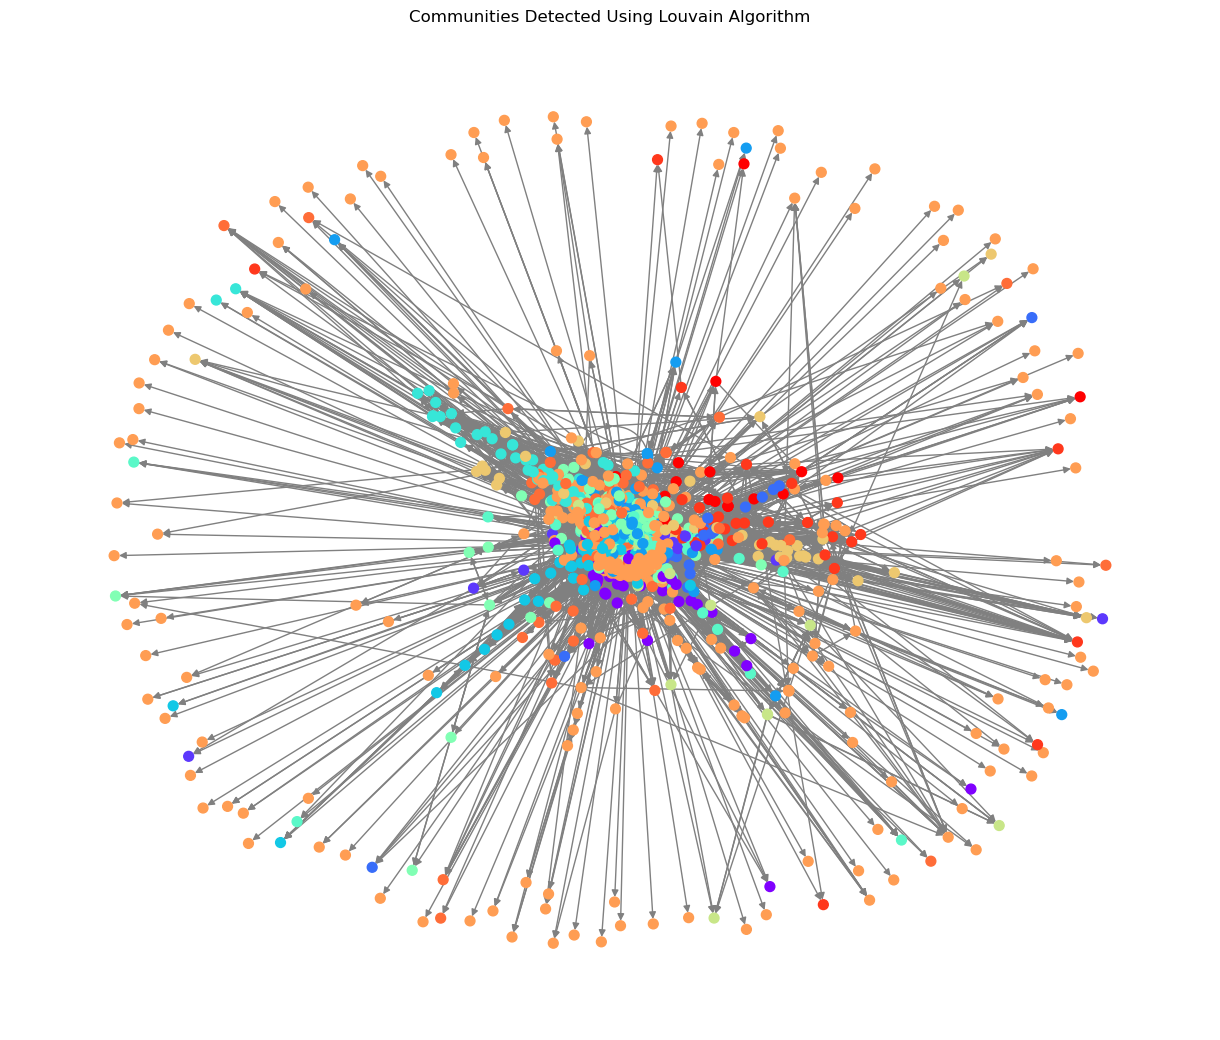

Number of internal edges in each community: [158, 84, 148, 374, 312, 314, 513, 1253, 42, 97, 266, 1058, 251, 148, 58]
Top central nodes in Community 0: [('25110374', 0.032403240324032405), ('3004231', 0.025202520252025202), ('23151437', 0.023402340234023402), ('16051471', 0.018901890189018902), ('17169320', 0.017101710171017102)]
Top central nodes in Community 1: [('18057537', 0.019801980198019802), ('17796018', 0.018001800180018002), ('8644082', 0.016201620162016202), ('2869531', 0.0144014401440144), ('21772005', 0.0144014401440144)]
Top central nodes in Community 2: [('746323', 0.0531053105310531), ('16134837', 0.026102610261026102), ('11148342', 0.025202520252025202), ('5485192', 0.025202520252025202), ('14986716', 0.022502250225022502)]
Top central nodes in Community 3: [('3359851', 0.1026102610261026), ('5442012', 0.045004500450045004), ('3040621', 0.037803780378037805), ('7872262', 0.0333033303330333), ('22784458', 0.0315031503150315)]
Top central nodes in Community 4: [('7861312

In [232]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt

communities = louvain_communities(subset_G, resolution=1, threshold=1e-07, seed=42)

# Number of communities
print(f"Total number of communities: {len(communities)}")

# Size of each community
community_sizes = [len(community) for community in communities]
print("Sizes of communities:", community_sizes)


#Visualize the Communities
def visualize_communities(graph, communities):
    # Assign colors to nodes based on their community
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}
    node_colors = [community_map[node] for node in graph.nodes()]
    
    # Generate layout for better visualization
    pos = nx.spring_layout(graph)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    nx.draw(
        graph, pos,
        node_color=node_colors,
        with_labels=False,
        cmap=plt.cm.rainbow,
        node_size=50,
        edge_color="gray"
    )
    plt.title("Communities Detected Using Louvain Algorithm")
    
    # Save the plot
    plt.savefig("ScreenShots/louvain_communities.png", format="png", dpi=300)  # Save as PNG with high resolution
    plt.show()

# Call visualization
visualize_communities(subset_G, communities)


internal_edges = [subset_G.subgraph(community).number_of_edges() for community in communities]
print("Number of internal edges in each community:", internal_edges)

degree_centrality = nx.degree_centrality(subset_G)
for idx, community in enumerate(communities):
    centrality = {node: degree_centrality[node] for node in community}
    sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
    print(f"Top central nodes in Community {idx}:", sorted_centrality[:5])

for idx, community in enumerate(communities):
    print(f"Community {idx}:")
    print(f"Size: {len(community)}")
    print(f"Internal Edges: {internal_edges[idx]}")
    print(f"Top central nodes: {sorted_centrality[:5]}")


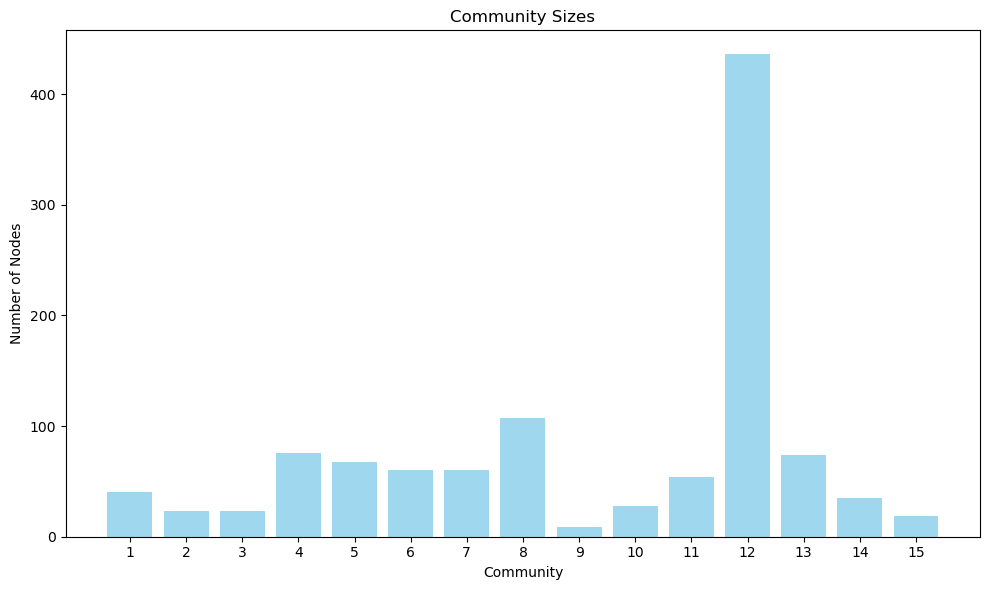

In [233]:
import matplotlib.pyplot as plt

community_numbers = list(range(1, len(community_sizes) + 1))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(community_numbers, community_sizes, color='skyblue', alpha=0.8)
plt.title("Community Sizes")
plt.xlabel("Community")
plt.ylabel("Number of Nodes")
plt.xticks(community_numbers)  # Set custom x-ticks to show community numbers
plt.tight_layout()
output_path = "network_community_sizes.png"  # Change the name or format if needed
plt.savefig(output_path, format="png", dpi=300)
plt.show()

In [234]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(subset_G)

# Identify top nodes in each community
for idx, community in enumerate(communities):
    top_node = max(community, key=lambda node: degree_centrality[node])
    print(f"Community {idx + 1}: Top node {top_node} (Degree Centrality: {degree_centrality[top_node]:.3f})")


Community 1: Top node 25110374 (Degree Centrality: 0.032)
Community 2: Top node 18057537 (Degree Centrality: 0.020)
Community 3: Top node 746323 (Degree Centrality: 0.053)
Community 4: Top node 3359851 (Degree Centrality: 0.103)
Community 5: Top node 7861312 (Degree Centrality: 0.111)
Community 6: Top node 30313925 (Degree Centrality: 0.090)
Community 7: Top node 10350 (Degree Centrality: 0.131)
Community 8: Top node 13348 (Degree Centrality: 0.131)
Community 9: Top node 815587 (Degree Centrality: 0.014)
Community 10: Top node 2735631 (Degree Centrality: 0.026)
Community 11: Top node 16129920 (Degree Centrality: 0.050)
Community 12: Top node 813286 (Degree Centrality: 1.672)
Community 13: Top node 14511951 (Degree Centrality: 0.063)
Community 14: Top node 8170292 (Degree Centrality: 0.046)
Community 15: Top node 5988062 (Degree Centrality: 0.023)


In [235]:
# Intra-community edges
def intra_community_edges(graph, community):
    return graph.subgraph(community).number_of_edges()

# Inter-community edges
def inter_community_edges(graph, community1, community2):
    return len([
        (u, v) for u in community1 for v in community2 if graph.has_edge(u, v)
    ])

# Compute edge metrics
for idx1, community1 in enumerate(communities):
    # Intra-community edges for community1
    intra_edges = intra_community_edges(subset_G, community1)
    print(f"Community {idx1 + 1}: {len(community1)} nodes, {intra_edges} intra-community edges")

    # Inter-community edges for each pair of communities
    for idx2, community2 in enumerate(communities):
        if idx1 < idx2:  # To avoid double-counting edges between the same communities
            inter_edges = inter_community_edges(subset_G, community1, community2)
            print(f"Inter-community edges between Community {idx1 + 1} and Community {idx2 + 1}: {inter_edges}")


Community 1: 40 nodes, 158 intra-community edges
Inter-community edges between Community 1 and Community 2: 0
Inter-community edges between Community 1 and Community 3: 0
Inter-community edges between Community 1 and Community 4: 1
Inter-community edges between Community 1 and Community 5: 1
Inter-community edges between Community 1 and Community 6: 3
Inter-community edges between Community 1 and Community 7: 2
Inter-community edges between Community 1 and Community 8: 8
Inter-community edges between Community 1 and Community 9: 0
Inter-community edges between Community 1 and Community 10: 0
Inter-community edges between Community 1 and Community 11: 0
Inter-community edges between Community 1 and Community 12: 39
Inter-community edges between Community 1 and Community 13: 10
Inter-community edges between Community 1 and Community 14: 0
Inter-community edges between Community 1 and Community 15: 0
Community 2: 23 nodes, 84 intra-community edges
Inter-community edges between Community 2

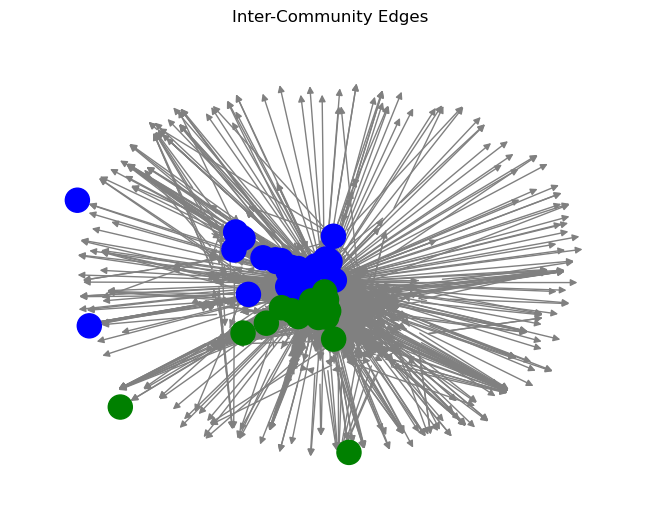

In [236]:
def visualize_inter_community_edges(graph, comm1, comm2):
    pos = nx.spring_layout(graph)
    nx.draw(
        graph, pos,
        nodelist=list(comm1) + list(comm2),
        node_color=["blue"] * len(comm1) + ["green"] * len(comm2),
        with_labels=False,
        edge_color="gray"
    )
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=[(u, v) for u in comm1 for v in comm2 if graph.has_edge(u, v)],
        edge_color="red"
    )
    plt.title("Inter-Community Edges")
    plt.show()

# Visualize edges between Community 1 and Community 2
visualize_inter_community_edges(subset_G, communities[0], communities[1])


In [237]:
from networkx.algorithms.community.quality import modularity

# Compute modularity
modularity_score = modularity(subset_G, communities)
print(f"Modularity of the partition: {modularity_score:.3f}")

for idx, community in enumerate(communities):
    subgraph = subset_G.subgraph(community)
    density = nx.density(subgraph)
    print(f"Community {idx + 1}: Density = {density:.3f}")


Modularity of the partition: 0.508
Community 1: Density = 0.101
Community 2: Density = 0.166
Community 3: Density = 0.292
Community 4: Density = 0.066
Community 5: Density = 0.068
Community 6: Density = 0.089
Community 7: Density = 0.145
Community 8: Density = 0.110
Community 9: Density = 0.583
Community 10: Density = 0.128
Community 11: Density = 0.093
Community 12: Density = 0.006
Community 13: Density = 0.046
Community 14: Density = 0.124
Community 15: Density = 0.170


Features analysis in a ego-network:

In [239]:
import pandas as pd

ego_node = '759679'
nodeId_file_path = f"twitter/{ego_node}.edges"
nodeId_G = nx.read_edgelist(nodeId_file_path,create_using=nx.DiGraph) #edges are directed


nodes_in_graph = list(nodeId_G.nodes())
print(nodeId_G.number_of_nodes())
# Add edges from the ego node to every other node
for node in nodes_in_graph:
    if node != ego_node:
        nodeId_G.add_edge(ego_node, node)

    
# Load features
feat_file = f"twitter/{ego_node}.feat"
features_df = pd.read_csv(feat_file, sep='\\s+', header=None)

# Separate node IDs and feature vectors
node_ids = features_df.iloc[:, 0]  # First column: node IDs
feature_vectors = features_df.iloc[:, 1:]  # Remaining columns: binary features

node_feature_dict = features_df.set_index(0).T.to_dict('list')

# Check the size of the ego features
ego_feat_file = f"twitter/{ego_node}.egofeat"
ego_features = pd.read_csv(ego_feat_file, sep='\\s+', header=None).iloc[0].tolist()
print(f"Ego Features Size: {len(ego_features)}")

# Add ego features to the dictionary (optional)
node_feature_dict[int(ego_node)] = ego_features



115
Ego Features Size: 383


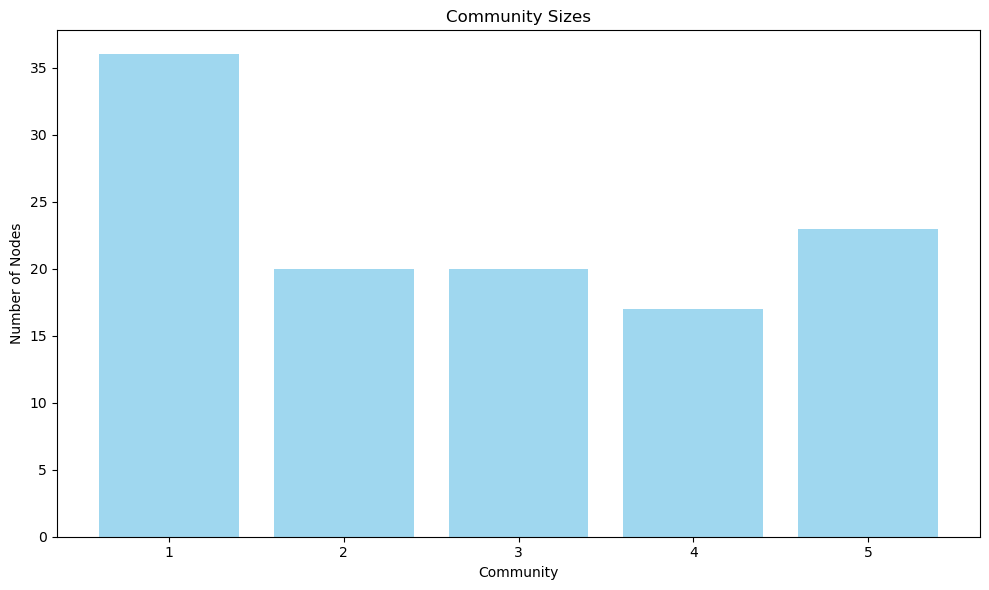

Community Sizes:
Community 1: 36 nodes
Community 2: 20 nodes
Community 3: 20 nodes
Community 4: 17 nodes
Community 5: 23 nodes


In [240]:
community_features = []



nodeId_communities = louvain_communities(nodeId_G, resolution=1, threshold=1e-07, seed=42)

for idx, community in enumerate(nodeId_communities):
    # Get feature vectors for all nodes in the community
    community_nodes = [int(node) for node in community if int(node) in node_feature_dict]
    community_feats = [node_feature_dict[node] for node in community_nodes]
   
    if community_feats:
        aggregated_features = pd.DataFrame(community_feats).mean(axis=0).tolist()  # Average features
    else:
        aggregated_features = []
    
    community_features.append({
        "Community": idx,
        "Nodes": len(community_nodes),
        "Aggregated Features": aggregated_features
    })

nodeId_community_sizes = [len(community) for community in nodeId_communities]
community_numbers = list(range(1, len(nodeId_community_sizes) + 1))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(community_numbers, nodeId_community_sizes, color='skyblue', alpha=0.8)
plt.title("Community Sizes")
plt.xlabel("Community")
plt.ylabel("Number of Nodes")
plt.xticks(community_numbers)  # Set custom x-ticks to show community numbers
plt.tight_layout()
output_path = f"{ego_node}_community_sizes.png"  # Change the name or format if needed
plt.savefig(output_path, format="png", dpi=300)
plt.show()

print("Community Sizes:")
for idx, size in enumerate(nodeId_community_sizes):
    print(f"Community {idx + 1}: {size} nodes")


Total Features: 383
Community 1:
  Number of Nodes: 36
Community 2:
  Number of Nodes: 20
Community 3:
  Number of Nodes: 20
Community 4:
  Number of Nodes: 17
Community 5:
  Number of Nodes: 23


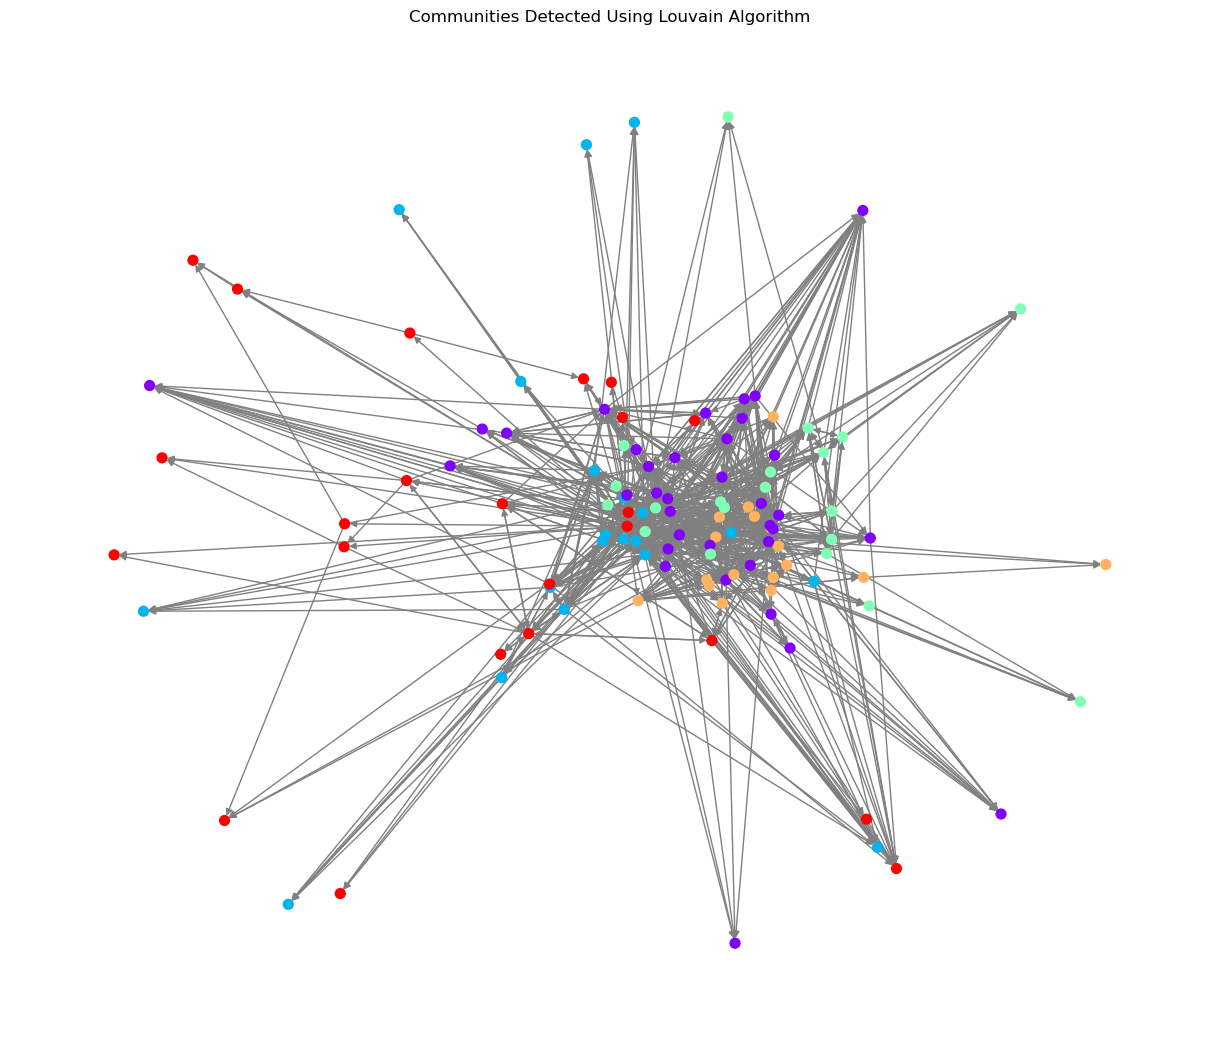

Top 10 most variable features:

Feature: 29 #MyGoals
  Community 0: 0.0
  Community 1: 0.25
  Community 2: 0.0
  Community 3: 0.0
  Community 4: 0.0

Feature: 202 @agentsilverfox
  Community 0: 0.0
  Community 1: 0.25
  Community 2: 0.05
  Community 3: 0.0
  Community 4: 0.043478260869565216

Feature: 288 @lisahubbert
  Community 0: 0.0
  Community 1: 0.0
  Community 2: 0.1
  Community 3: 0.23529411764705882
  Community 4: 0.0

Feature: 203 @agentsilverfox:
  Community 0: 0.0
  Community 1: 0.25
  Community 2: 0.05
  Community 3: 0.0
  Community 4: 0.08695652173913043

Feature: 222 @chadallen
  Community 0: 0.0
  Community 1: 0.0
  Community 2: 0.05
  Community 3: 0.0
  Community 4: 0.21739130434782608

Feature: 315 @pacoallen
  Community 0: 0.0
  Community 1: 0.15
  Community 2: 0.2
  Community 3: 0.23529411764705882
  Community 4: 0.08695652173913043

Feature: 147 @JamesGunaca
  Community 0: 0.0
  Community 1: 0.2
  Community 2: 0.0
  Community 3: 0.0
  Community 4: 0.0

Feature: 292

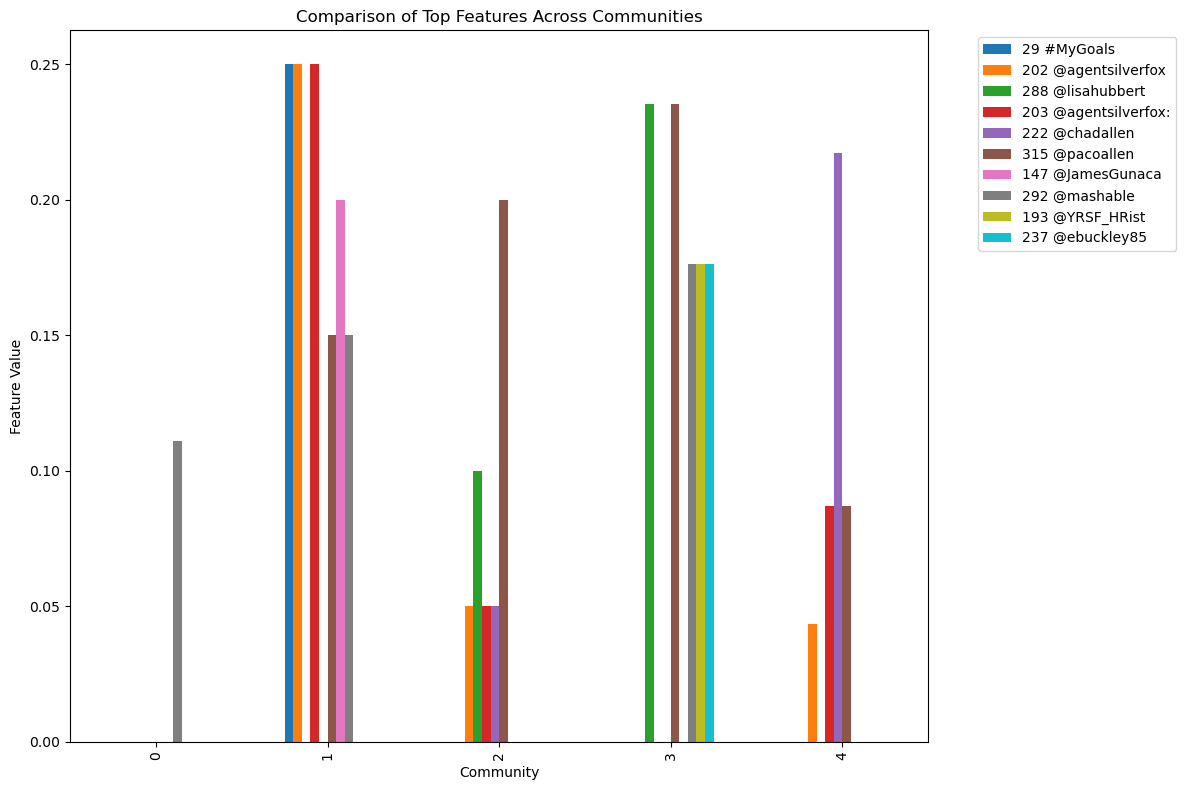

In [241]:
import pandas as pd
import matplotlib.pyplot as plt

featnames_file = f"twitter/{ego_node}.featnames"

# Open the file with UTF-8 encoding
with open(featnames_file, "r", encoding="utf-8") as f:
    feature_names = [line.strip() for line in f]

print(f"Total Features: {len(feature_names)}")


community_features = []



for idx, community in enumerate(nodeId_communities):
    # Get feature vectors for all nodes in the community
    community_nodes = [int(node) for node in community]
    community_feats = [node_feature_dict[node] for node in community_nodes]
    
    # Aggregate features
    if community_feats:
        aggregated_features = pd.DataFrame(community_feats).mean(axis=0).tolist()  # Average features
    else:
        aggregated_features = []
    
    # Map aggregated features to feature names
    feature_summary = dict(zip(feature_names, aggregated_features)) if aggregated_features else {}

    community_features.append({
        "Community": idx + 1,
        "Nodes": len(community_nodes),
        "Feature Summary": feature_summary
    })

# Print summary of community features with feature names
for cf in community_features:
    print(f"Community {cf['Community']}:")
    print(f"  Number of Nodes: {cf['Nodes']}")


def plot_feature_comparison(community_features, top_k=10, output_file="feature_comparison.png"):
    # Extract features for visualization as a DataFrame
    feature_df = pd.DataFrame([
        cf["Feature Summary"] for cf in community_features
    ])
    
    # Find top-k most variable features across communities
    variances = feature_df.var(axis=0)
    top_features = variances.nlargest(top_k).index  # These are feature names (strings)

      # Print the top features for each community
    print(f"Top {top_k} most variable features:")
    for feature in top_features:
        print(f"\nFeature: {feature}")
        for community_idx, community in enumerate(community_features):
            feature_value = community["Feature Summary"].get(feature, "N/A")
            print(f"  Community {community_idx}: {feature_value}")
        
    # Plot
    feature_df[top_features].plot(kind='bar', figsize=(12, 8))
    plt.title("Comparison of Top Features Across Communities")
    plt.xlabel("Community")
    plt.ylabel("Feature Value")
    
    # Use top_features directly for the legend
    plt.legend(top_features, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_file, format="png", dpi=300)  # Save with high resolution
    
    plt.show()


visualize_communities(nodeId_G, nodeId_communities)
# Call plotting function and save the graph
plot_feature_comparison(community_features, top_k=10, output_file="ScreenShots/feature_comparison.png")

